# View Roadway

In [1]:
using AutomotiveDrivingModels

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "src", "viz", "AutoViz.jl"))
using AutoViz

In [3]:
function get_test_roadway()
    roadway = Roadway()

    seg1 = RoadSegment(1,
        [Lane(LaneTag(1,1),
            [CurvePt(VecSE2(-20.0,0.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(-10.0,0.0*DEFAULT_LANE_WIDTH,0.0), 1.0)]),
         Lane(LaneTag(1,2),
            [CurvePt(VecSE2(-20.0,1.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(-10.0,1.0*DEFAULT_LANE_WIDTH,0.0), 1.0)]),
         Lane(LaneTag(1,3),
            [CurvePt(VecSE2(-20.0,2.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(-10.0,2.0*DEFAULT_LANE_WIDTH,0.0), 1.0)])
        ])

    seg2 = RoadSegment(2,
        [Lane(LaneTag(2,1),
            [CurvePt(VecSE2(00.0,0.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(10.0,0.0*DEFAULT_LANE_WIDTH,0.0), 1.0),
             CurvePt(VecSE2(20.0,0.0*DEFAULT_LANE_WIDTH,0.0), 2.0),
             CurvePt(VecSE2(30.0,0.0*DEFAULT_LANE_WIDTH,0.0), 3.0)]),
         Lane(LaneTag(2,2),
            [CurvePt(VecSE2(00.0,1.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(10.0,1.0*DEFAULT_LANE_WIDTH,0.0), 1.0),
             CurvePt(VecSE2(20.0,1.0*DEFAULT_LANE_WIDTH,0.0), 2.0),
             CurvePt(VecSE2(30.0,1.0*DEFAULT_LANE_WIDTH,0.0), 3.0)]),
         Lane(LaneTag(2,3),
            [CurvePt(VecSE2(00.0,2.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(10.0,2.0*DEFAULT_LANE_WIDTH,0.0), 1.0),
             CurvePt(VecSE2(20.0,2.0*DEFAULT_LANE_WIDTH,0.0), 2.0),
             CurvePt(VecSE2(30.0,2.0*DEFAULT_LANE_WIDTH,0.0), 3.0)])
         ])

    seg3 = RoadSegment(3,
        [Lane(LaneTag(3,1),
            [CurvePt(VecSE2(40.0,0.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(50.0,0.0*DEFAULT_LANE_WIDTH,0.0), 1.0)]),
         Lane(LaneTag(3,2),
            [CurvePt(VecSE2(40.0,1.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(50.0,1.0*DEFAULT_LANE_WIDTH,0.0), 1.0)]),
         Lane(LaneTag(3,3),
            [CurvePt(VecSE2(40.0,2.0*DEFAULT_LANE_WIDTH,0.0), 0.0),
             CurvePt(VecSE2(50.0,2.0*DEFAULT_LANE_WIDTH,0.0), 1.0)])
        ])

    for i in 1:3
        connect!(seg1.lanes[i], seg2.lanes[i])
        connect!(seg2.lanes[i], seg3.lanes[i])
    end

    push!(roadway.segments, seg1)
    push!(roadway.segments, seg2)
    push!(roadway.segments, seg3)

    roadway
end

get_test_roadway (generic function with 1 method)

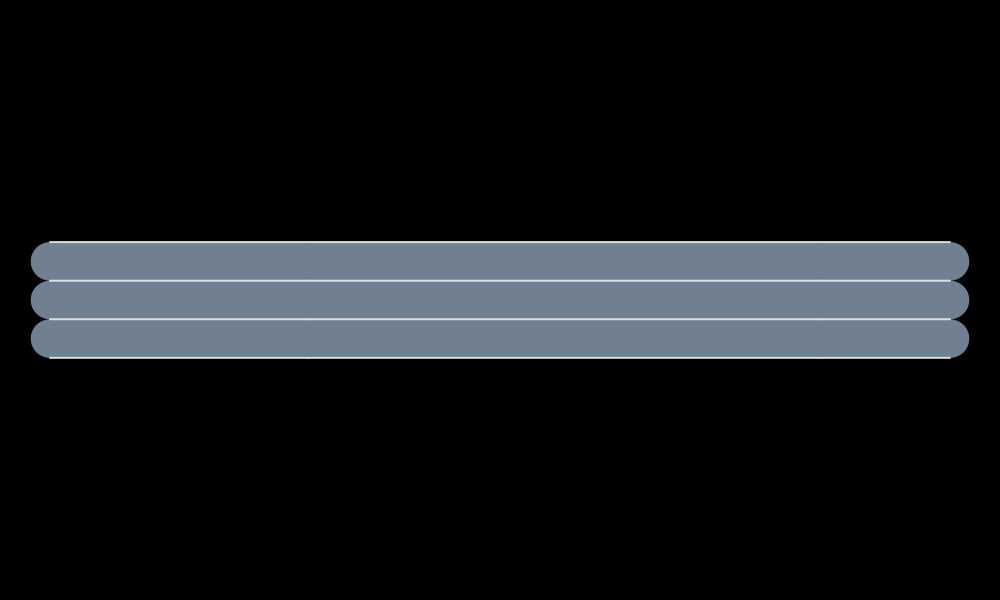

In [4]:
roadway = get_test_roadway()

rendermodel = RenderModel()
s = CairoRGBSurface(DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
ctx = creategc(s)
clear_setup!(rendermodel)

render!(rendermodel, roadway)

camera_fit_to_content!(rendermodel, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
render(rendermodel, ctx, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
s